In [1]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [2]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
from pathlib import Path
import pandas as pd

# do not change directory but still go to the folder with the models
folder = Path().cwd() / "cs_mods" / "August2023"
model_list = []
for file in folder.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file.stem # remove .xml 
    model.name = file.stem # remove .xml
    model_list.append(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [3]:
model_list

[<Model Human-GEM_28062023 at 0x21e086410c0>,
 <Model mod_RPE_PRcone_Liang at 0x21e535be530>,
 <Model mod_RPE_PRcone_Liang_singlePR at 0x21e542aa830>,
 <Model mod_RPE_PRcone_Liang_singleRPE at 0x21e5db3f280>,
 <Model mod_RPE_PRcone_Lukowski at 0x21e79253910>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x21e8a47f3a0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x21e8d653e50>,
 <Model mod_RPE_PRcontrol at 0x21e918cf8e0>,
 <Model mod_RPE_PRrod_Liang at 0x21eaa99f2b0>,
 <Model mod_RPE_PRrod_Liang_singlePR at 0x21ef9899390>,
 <Model mod_RPE_PRrod_Liang_singlePRE at 0x21efec2b1f0>,
 <Model mod_RPE_PRrod_Lukowski at 0x21f03a7ece0>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x21eff4c52a0>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x21f0fd70e50>]

In [4]:
# select only models containing Lukowski in their name 
model_list = [model for model in model_list if 'Lukowski' in model.id \
                        or 'Human-GEM' in model.id\
                        or 'control' in model.id]
model_list

[<Model Human-GEM_28062023 at 0x21e086410c0>,
 <Model mod_RPE_PRcone_Lukowski at 0x21e79253910>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x21e8a47f3a0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x21e8d653e50>,
 <Model mod_RPE_PRcontrol at 0x21e918cf8e0>,
 <Model mod_RPE_PRrod_Lukowski at 0x21f03a7ece0>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x21eff4c52a0>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x21f0fd70e50>]

In [5]:
# modify models

# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
        m.reactions.get_by_id('MAR03964_PR').bounds = (-1000,1000)
        m.objective.direction = 'max'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
        m.reactions.get_by_id('MAR03964_RPE').bounds = (-1000,1000)
        m.objective.direction = 'max'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
        m.reactions.get_by_id('MAR03964').bounds = (-1000,1000)
        m.objective.direction = 'max'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id and 'Human' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]
Human1_models = [m for m in model_list if 'Human' in m.id]

# allow all metabolites out (open efflux) and open influx for water
for m in model_list:
    for r in [r for r in m.reactions if len(r.products) == 0]:
        r.bounds = (0,0)
    for r in [r for r in m.reactions if len(r.products) == 0  if '_eRPE_PR' not in r.id]:  # open efflux for exchange reactions (except for with the RPE-PR[e] interface)
        r.bounds=(0,1000)
    for r in [r for r in m.reactions if 'MAR09047' in r.id and '_eRPE_PR' not in r.id]: # MAR09047: water
        r.bounds=(-1000,1000) 

In [6]:
print('list of H2O exchange reactions in model at position 1 in model_list:')
[r for r in model_list[1].reactions if 'MAR09047' in r.id]

list of H2O exchange reactions in model at position 1 in model_list:


[<Reaction MAR09047_RPE at 0x21e825e6230>,
 <Reaction MAR09047_eRPE_PR at 0x21e83649f30>,
 <Reaction MAR09047_PR at 0x21e8640f760>]

In [7]:
print('H2O exchange bounds with PR: ' + str(model_list[1].reactions.get_by_id('MAR09047_PR').bounds))
print('H2O exchange bounds with RPE: ' + str(model_list[1].reactions.get_by_id('MAR09047_RPE').bounds))
print('H2O exchange bounds with RPE-PR interface: ' + str(model_list[1].reactions.get_by_id('MAR09047_eRPE_PR').bounds))

H2O exchange bounds with PR: (-1000, 1000)
H2O exchange bounds with RPE: (-1000, 1000)
H2O exchange bounds with RPE-PR interface: (0, 0)


In [8]:
single_models

[<Model mod_RPE_PRcone_Lukowski_singlePR at 0x21e8a47f3a0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x21e8d653e50>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x21eff4c52a0>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x21f0fd70e50>]

In [9]:
Human1_models

[<Model Human-GEM_28062023 at 0x21e086410c0>]

In [10]:
Human1_models[0].reactions.get_by_id('MAR03964')

Reaction identifier,MAR03964
Name,ATP phosphohydrolase
Memory address,0x21e0ecdd780
Stoichiometry,MAM01371c + MAM02040c <=> MAM01285c + MAM02039c + MAM02751c ATP + H2O <=> ADP + H+ + Pi
GPR,
Lower bound,-1000
Upper bound,1000


In [11]:
# load blood exchange bounds
import pandas as pd
df = pd.read_excel(Path().cwd() / 'rxn_bounds/blood_selection.xlsx') # with col names 'id' 'lb' 'ub'
blood_ratio = {df['id_single'][i]:df['ratio [glucose]/[x]'] [i] for i in range(len(df['id']))}

# dictionary comprehension to replace values with 50% and 10% values in dict
blood_ratio200 = {k:2*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio100 = {k:1*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio50 = {k: 0.5*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio25 = {k: 0.25*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio0 = {k: 0.00*blood_ratio[k] for k in blood_ratio.keys()}

br_list = [blood_ratio200, blood_ratio100, blood_ratio50, blood_ratio25, blood_ratio0]

In [12]:
def open_blood_exchange(mod,br, glucose_level, RPE_PR = 'RPE'):  
    suffix = '_PR' if RPE_PR == 'PR' \
        else '_RPE' if RPE_PR == 'RPE' \
        else '' if RPE_PR == '' \
        else print('RPE_PR must be PR, RPE or empty string')

    br_updated = br.copy()
    br_updated.update((x, y * glucose_level) for x, y in br_updated.items())
    for key in br:
        if key in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key).bounds = (br_updated[key],1000)# allow influx for RPE exchange reactions (blood exchange)
        elif key + suffix in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + suffix).bounds = (br_updated[key],1000)
        elif key + '_RPE' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_RPE').bounds = (br_updated[key],1000)
        elif key + '_PR' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_PR').bounds = (br_updated[key],1000)
        else: 
            print(key + ' not in model')
    return mod


In [13]:
[[r.id, r.reaction] for r in model_list[1].reactions if 'MAR04896' in r.id]

[['MAR04896_RPE', 'MAM02630c_RPE <=> MAM02630e_RPE'],
 ['MAR04896_RPE_PR', 'MAM02630c_RPE <=> MAM02630e_RPE_PR'],
 ['MAR04896_PR', 'MAM02630c_PR <=> MAM02630e_PR'],
 ['MAR04896_PR_RPE', 'MAM02630c_PR <=> MAM02630e_RPE_PR']]

In [14]:
# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

##############################################################
#######    total exchange (for single models)        #########
##############################################################

single_ex_bounds_dark = {'MAR09048':(-4.04,-4.04),\
                      'MAR09034':(-4.81,-4.81),\
                        'MAR09135':(8.34,8.34)}

single_ex_bounds_light = {'MAR09048':(-2.76,-2.76),\
                       'MAR09034':(-2.05,-2.05),\
                        'MAR09135':(4.21,4.21)}

##############################################################
##############     CC exchange  (CC --> RPE)  ################
####  inner retina exchange  (retina vasculature --> PR)  ####
##############################################################

ex_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
                     'MAR04896_PR_RPE':(-3.18,-3.18),\
                      'MAR09034_RPE':(-4.14,-4.14),\
                      'MAR09135_RPE':(7.18,7.18),\
                      'MAR09048_PR':(-0.56,-0.56),\
                      'MAR09034_PR':(-0.67,-0.67),\
                      'MAR09135_PR':(1.16,1.16)}          

ex_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
                      'MAR04896_PR_RPE':(-2.19,-2.19),\
                      'MAR09034_RPE':(-1.84,-1.84),\
                      'MAR09135_RPE':(3.79,3.79),\
                      'MAR09048_PR':(-0.27,-0.27),\
                      'MAR09034_PR':(-0.20,-0.20),\
                      'MAR09135_PR':(0.41,0.41)}


##############################################################
##############     for combined models      ##################
##############################################################

results_dict_dark = {}
results_dict_light = {}
for model in combined_models:
    with model as m:
        for br in br_list:
            m = open_blood_exchange(m,br, -4.14, 'RPE')
            m = open_blood_exchange(m,br,  -0.67, 'PR')
            for ex in ex_bounds_dark.keys(): 
                m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds
            m.optimize()
            results_dict_dark[str(m.id) + str(list(br.values())[0])]  = m.objective.value

            m = open_blood_exchange(m,br, -1.84, 'RPE')
            m = open_blood_exchange(m,br,  -.20, 'PR')
            for ex in ex_bounds_light.keys(): 
                m.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds
            m.optimize()
            results_dict_light[str(m.id) + str(list(br.values())[0])] = m.objective.value

df1 = pd.DataFrame(results_dict_light, index = ['light']).T
df2 = pd.DataFrame(results_dict_dark, index = ['dark']).T
results1 = pd.concat([df1,df2], axis = 1)

print('COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2)')
results1

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2)


c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


,light,dark
mod_RPE_PRcone_Lukowski2.0,17.927194,30.611575
mod_RPE_PRcone_Lukowski1.0,17.585718,30.043288
mod_RPE_PRcone_Lukowski0.5,8.248779,29.759144
mod_RPE_PRcone_Lukowski0.25,None,29.617072
mod_RPE_PRcone_Lukowski0.0,None,27.900000
mod_RPE_PRcontrol2.0,18.415882,31.861471
mod_RPE_PRcontrol1.0,17.808396,30.667099
mod_RPE_PRcontrol0.5,16.935432,30.069913
mod_RPE_PRcontrol0.25,9.699103,29.771320
mod_RPE_PRcontrol0.0,None,28.500000


In [15]:
combined_models[0].reactions.get_by_id('MAR04896_PR_RPE')

Reaction identifier,MAR04896_PR_RPE
Name,
Memory address,0x21e87322ec0
Stoichiometry,MAM02630c_PR <=> MAM02630e_RPE_PR O2 <=> O2
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [16]:
from src.get_info import make_rxn_df    
df = make_rxn_df(combined_models[1])
df.to_clipboard()

In [17]:
results_dict_dark_single = {}
results_dict_light_single = {}

for model in single_models + Human1_models:
    with model as m:
        for br in br_list:
            m = open_blood_exchange(m,br, -4.14-0.67, '')
            reactions_list = [r.id for r in m.reactions]
            for ex in single_ex_bounds_dark.keys(): 
                if (ex + '_RPE') in reactions_list:
                    m.reactions.get_by_id(ex + '_RPE').bounds = single_ex_bounds_dark[ex] # set exchange bounds
                elif (ex + '_PR') in reactions_list:
                    m.reactions.get_by_id(ex + '_PR').bounds = single_ex_bounds_dark[ex] # set exchange bounds
                elif (ex) in reactions_list:
                    m.reactions.get_by_id(ex).bounds = single_ex_bounds_dark[ex]
                else:
                    print('exchange reaction not found')
            m.optimize()
            results_dict_dark_single[m.id+ str(list(br.values())[0])] = m.objective.value

            m = open_blood_exchange(m,br, -1.84-.20, '')
            for ex in single_ex_bounds_light.keys(): 
                if (ex + '_RPE') in reactions_list:
                    m.reactions.get_by_id(ex + '_RPE').bounds = single_ex_bounds_light[ex]
                elif (ex + '_PR') in reactions_list:
                    m.reactions.get_by_id(ex + '_PR').bounds = single_ex_bounds_light[ex]
                elif (ex) in reactions_list:
                    m.reactions.get_by_id(ex).bounds = single_ex_bounds_light[ex]
                else:   
                    print('exchange reaction not found')
            m.optimize()
            results_dict_light_single[m.id+ str(list(br.values())[0])] = m.objective.value

df1 = pd.DataFrame(results_dict_light_single, index = ['light']).T
df2 = pd.DataFrame(results_dict_dark_single, index = ['dark']).T
results2 = pd.concat([df1,df2], axis = 1)

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2)')
results2

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2)


c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


,light,dark
mod_RPE_PRcone_Lukowski_singlePR2.0,15.731013,29.724091
mod_RPE_PRcone_Lukowski_singlePR1.0,12.712931,28.082527
mod_RPE_PRcone_Lukowski_singlePR0.5,None,27.226263
mod_RPE_PRcone_Lukowski_singlePR0.25,None,26.798132
mod_RPE_PRcone_Lukowski_singlePR0.0,None,25.020000
mod_RPE_PRcone_Lukowski_singleRPE2.0,17.121676,29.642356
mod_RPE_PRcone_Lukowski_singleRPE1.0,8.333642,29.238321
mod_RPE_PRcone_Lukowski_singleRPE0.5,None,28.840982
mod_RPE_PRcone_Lukowski_singleRPE0.25,None,28.640491
mod_RPE_PRcone_Lukowski_singleRPE0.0,None,26.940000


In [18]:
#combine results1 and results2
results = pd.concat([results1,results2], axis = 0)
# melt results to long format
results_long = results.reset_index()
results_long = results_long.rename(columns = {'index':'model'})
results_long = results_long.melt(id_vars = 'model', var_name = 'light/dark', value_name = 'ATP hydrolysis (pmol/s/mm^2)')
# for model column in results_long, pattern recognition 'single' and move to new column 'model type'
results_long

,model,light/dark,ATP hydrolysis (pmol/s/mm^2)
0,mod_RPE_PRcone_Lukowski2.0,light,17.927194
1,mod_RPE_PRcone_Lukowski1.0,light,17.585718
2,mod_RPE_PRcone_Lukowski0.5,light,8.248779
3,mod_RPE_PRcone_Lukowski0.25,light,None
4,mod_RPE_PRcone_Lukowski0.0,light,None
...,...,...,...
75,Human-GEM_280620232.0,dark,31.861471
76,Human-GEM_280620231.0,dark,30.667099
77,Human-GEM_280620230.5,dark,30.069913
78,Human-GEM_280620230.25,dark,29.77132


In [19]:

# if model column contains 'single' or 'Human1' put 'single in column 'model type' otherwise put 'combined'
results_long['single/combined'] = ['single' if 'single' in model else 'single' if 'Human' in model else 'combined' for model in results_long['model']]
# add column with last number (2.0,1.0,0.5,0.25, or 0.0) of model column
results_long['aa_ratio'] = [model[-3:] for model in results_long['model']]
# if patern 'mod_RPE_PRcone' AND 'single' in model columns, put 'PR cone' in column 'cell'
m1 = ['PR cone' if 'mod_RPE_PRcone' in model and 'singlePR' in model else '' for model in results_long['model']]
m2 = ['RPE - PR cone' if 'mod_RPE_PRcone' in model and 'single' not in model else '' for model in results_long['model']]
m3 = ['PR rod' if 'mod_RPE_PRrod' in model and 'singlePR' in model else '' for model in results_long['model']]
m4 = ['RPE - PR rod' if 'mod_RPE_PRrod' in model and 'single' not in model else ''  for model in results_long['model']]
m5 = ['RPE' if 'singleRPE' in model else ''  for model in results_long['model']]
m6 = ['RPE - PR control' if 'control' in model and 'single' not in model else ''  for model in results_long['model']]
m7 = ['control' if 'Human' in model else ''  for model in results_long['model']]
# combine m1 to m5 in one columns 'cell'
results_long['cell'] = [m1[i] + m2[i] + m3[i] + m4[i] + m5[i]+ m6[i] + m7[i] for i in range(len(m1))]
results_long.to_clipboard()
results_long

,model,light/dark,ATP hydrolysis (pmol/s/mm^2),single/combined,aa_ratio,cell
0,mod_RPE_PRcone_Lukowski2.0,light,17.927194,combined,2.0,RPE - PR cone
1,mod_RPE_PRcone_Lukowski1.0,light,17.585718,combined,1.0,RPE - PR cone
2,mod_RPE_PRcone_Lukowski0.5,light,8.248779,combined,0.5,RPE - PR cone
3,mod_RPE_PRcone_Lukowski0.25,light,None,combined,.25,RPE - PR cone
4,mod_RPE_PRcone_Lukowski0.0,light,None,combined,0.0,RPE - PR cone
...,...,...,...,...,...,...
75,Human-GEM_280620232.0,dark,31.861471,single,2.0,control
76,Human-GEM_280620231.0,dark,30.667099,single,1.0,control
77,Human-GEM_280620230.5,dark,30.069913,single,0.5,control
78,Human-GEM_280620230.25,dark,29.77132,single,.25,control


In [20]:
# turn 	ATP hydrolysis (pmol/s/mm^2) columns into numeric
results_long['ATP hydrolysis (pmol/s/mm^2)'] = pd.to_numeric(results_long['ATP hydrolysis (pmol/s/mm^2)'])
results_long
#save results_long to excel
results_long.to_excel(Path().home() / 'results' / 'ATP_FBA_aa.xlsx')
results.to_excel(Path().home() / 'results' / 'ATP_FBA_aa_short.xlsx')

In [21]:
# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['aa_ratio'].isin(['1.0','0.0'])] 

results_long1

,model,light/dark,ATP hydrolysis (pmol/s/mm^2),single/combined,aa_ratio,cell
1,mod_RPE_PRcone_Lukowski1.0,light,17.585718,combined,1.0,RPE - PR cone
4,mod_RPE_PRcone_Lukowski0.0,light,NaN,combined,0.0,RPE - PR cone
6,mod_RPE_PRcontrol1.0,light,17.808396,combined,1.0,RPE - PR control
9,mod_RPE_PRcontrol0.0,light,NaN,combined,0.0,RPE - PR control
11,mod_RPE_PRrod_Lukowski1.0,light,17.585718,combined,1.0,RPE - PR rod
14,mod_RPE_PRrod_Lukowski0.0,light,NaN,combined,0.0,RPE - PR rod
16,mod_RPE_PRcone_Lukowski_singlePR1.0,light,12.712931,single,1.0,PR cone
19,mod_RPE_PRcone_Lukowski_singlePR0.0,light,NaN,single,0.0,PR cone
21,mod_RPE_PRcone_Lukowski_singleRPE1.0,light,8.333642,single,1.0,RPE
24,mod_RPE_PRcone_Lukowski_singleRPE0.0,light,NaN,single,0.0,RPE


C:\Users\prins\AppData\Local\Temp\ipykernel_17972\4270048526.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(data=results_long1, x='cell', \


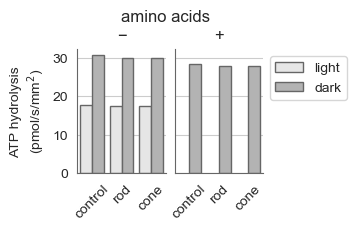

In [22]:
# create a barplot
# change order 
# define the palette with grey and white colors
import seaborn as sns
import matplotlib.pyplot as plt

my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['aa_ratio'].isin(['1.0','0.0'])] 
results_long1 = results_long1[results_long1['single/combined'].isin(['combined'])]

cell_order = ['RPE - PR control','RPE - PR rod','RPE - PR cone']
results_long1['cell'] = pd.Categorical(results_long1['cell'], categories = cell_order, ordered = True)
# set whitegrid style
sns.set_style("whitegrid")


g = sns.catplot(data=results_long1, x='cell', \
            y='ATP hydrolysis (pmol/s/mm^2)',\
             hue='light/dark',\
            kind='bar', \
            col='aa_ratio',\
            ci='sd',\
            palette = my_palette, legend=False)

# rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('')

plt.gcf().set_size_inches(2,1.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('ATP hydrolysis\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# REMOVE x axis title
ax.set_xlabel('') 

# CHANGE X tick labels
plt.gcf().axes[0].set_xticklabels(['control','rod','cone'])

# increase space betwen plots
plt.subplots_adjust(hspace = 0.3)

# change titles of subplots
titles = ['−', '+']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)
    
# create suptitle
plt.suptitle('amino acids', y = 1.2)

# Remove legends from both subplots
plt.gcf().axes[0].legend().remove()
plt.gcf().axes[1].legend().remove()

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
# increase space between plots
plt.subplots_adjust(wspace = 0.1)
# move legend to the right
plt.gcf().axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
#remove other legend
plt.gcf().axes[0].legend().remove()

# save figure in results folder in user folder
plt.savefig(Path().home() / 'results' / 'ATP_FBA_aas_noaas_combined.png', dpi=300, bbox_inches='tight')

C:\Users\prins\AppData\Local\Temp\ipykernel_17972\2571135307.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long1['aa_ratio'] = pd.Categorical(results_long1['aa_ratio'], categories=aa_order, ordered=True)
C:\Users\prins\AppData\Local\Temp\ipykernel_17972\2571135307.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long1['cell'] = pd.Categorical(results_long1['cell'], categories = cell_order, ordered = True)
C:\Users\prins\AppData\Local\Temp\ipykernel_17972\2571135307.py:17: FutureWa

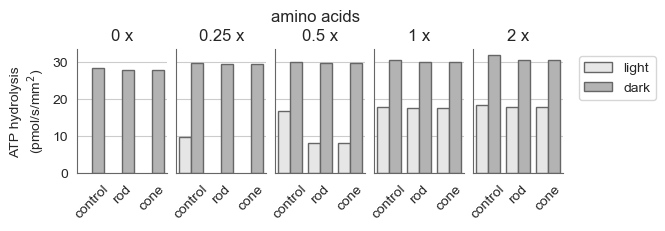

In [23]:
# create a barplot
# change order 
# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)


# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['single/combined'].isin(['combined'])]
cell_order = ['RPE - PR control','RPE - PR rod','RPE - PR cone']
aa_order = ['0.0','.25','0.5','1.0','2.0']
# convert aa_ratio column to categorical variable with desired order
results_long1['aa_ratio'] = pd.Categorical(results_long1['aa_ratio'], categories=aa_order, ordered=True)
results_long1['cell'] = pd.Categorical(results_long1['cell'], categories = cell_order, ordered = True)


g = sns.catplot(data=results_long1, x='cell', \
            y='ATP hydrolysis (pmol/s/mm^2)',\
             hue='light/dark',\
            kind='bar', \
            col='aa_ratio',\
            ci='sd',\
            palette=my_palette, legend=False)

plt.gcf().axes[0].set_xticklabels(cell_order)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(5,1.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('ATP hydrolysis\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# CHANGE X tick labels
plt.gcf().axes[0].set_xticklabels(['control','rod','cone'])

# REMOVE x axis title
ax.set_xlabel('') 

# increase space between plots
plt.subplots_adjust(wspace = 0.1)

# create suptitle
plt.suptitle('amino acids', y = 1.2)

# change titles of subplots
titles = ['0 x', '0.25 x', '0.5 x','1 x','2 x']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

# Remove legends from both subplots for all axes
for ax in plt.gcf().axes:
    ax.legend().remove()

# rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('')


# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(5.5, 1.0))

# save figure in results folder in user folder
plt.savefig(Path().home() / 'results' / 'ATP_FBA_levels_aas.png', dpi=300, bbox_inches='tight')

C:\Users\prins\AppData\Local\Temp\ipykernel_17972\3549364961.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long1['cell'] = pd.Categorical(results_long1['cell'], categories=cell_order, ordered=True)
C:\Users\prins\AppData\Local\Temp\ipykernel_17972\3549364961.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.catplot(data=results_long1, x='cell', \


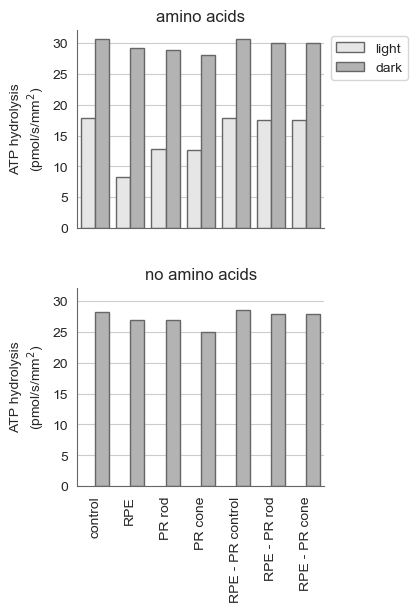

In [24]:
# create a barplot
# change order 

# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['aa_ratio'].isin(['1.0','0.0'])] 

cell_order = ['control', 'RPE','PR rod','PR cone','RPE - PR control','RPE - PR rod','RPE - PR cone']
results_long1['cell'] = pd.Categorical(results_long1['cell'], categories=cell_order, ordered=True)

sns.catplot(data=results_long1, x='cell', \
            y='ATP hydrolysis (pmol/s/mm^2)',\
             hue='light/dark',\
            kind='bar', \
            row='aa_ratio',\
            ci='sd',\
            palette=my_palette, \
            legend=False)

plt.xticks(rotation=90)
plt.gcf().set_size_inches(3,5)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('ATP hydrolysis\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# REMOVE x axis title
ax.set_xlabel('') 

# increase space betwen plots
plt.subplots_adjust(hspace = 0.3)

# change titles of subplots
titles = ['amino acids', 'no amino acids']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

# Remove legends from both subplots
plt.gcf().axes[0].legend().remove()
plt.gcf().axes[1].legend().remove()

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# save figure in results folder in user folder
plt.savefig(Path().home() / 'results' / 'ATP_FBA_aas_noaas.png', dpi=300, bbox_inches='tight')

C:\Users\prins\AppData\Local\Temp\ipykernel_17972\1077870288.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.catplot(data=results_long2, x='cell', \


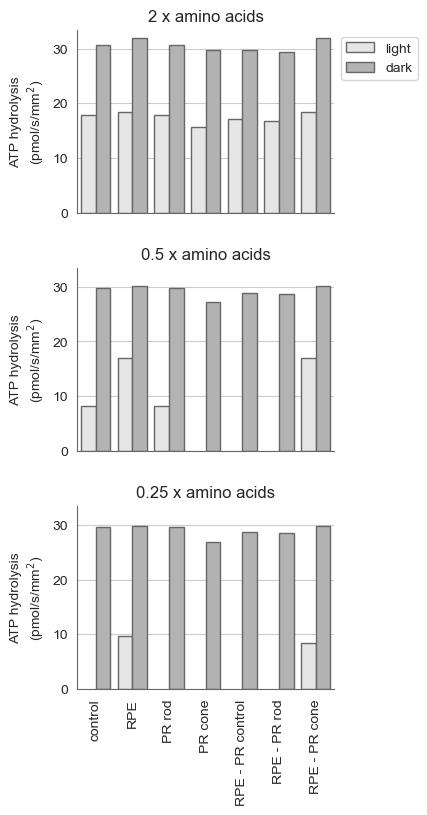

In [25]:
# create a barplot
# change order 
# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

# select only rows with 1.0 or 0.0 in aa_ratio column
results_long2 = results_long[results_long['aa_ratio'].isin(['2.0','0.5','.25'])] 

cell_order = ['control', 'RPE','PR rod','PR cone','RPE - PR control','RPE - PR rod','RPE - PR cone']

sns.catplot(data=results_long2, x='cell', \
            y='ATP hydrolysis (pmol/s/mm^2)',\
             hue='light/dark',\
            kind='bar', \
            row='aa_ratio',\
            ci='sd',\
            palette=my_palette, legend=False)

plt.gcf().axes[0].set_xticklabels(cell_order)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(3,7)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('ATP hydrolysis\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# REMOVE x axis title
ax.set_xlabel('') 

# increase space betwen plots
plt.subplots_adjust(hspace = 0.3)

# change titles of subplots
titles = ['2 x amino acids', '0.5 x amino acids','0.25 x amino acids']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

# Remove legends from both subplots
plt.gcf().axes[0].legend().remove()
plt.gcf().axes[1].legend().remove()
plt.gcf().axes[2].legend().remove()

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# save figure in results folder in user folder
plt.savefig(Path().home() / 'results' / 'ATP_FBA_aas.png', dpi=300, bbox_inches='tight')

In [26]:
def my_range(start, end, step):
    return [round(start + i * step, 1) for i in range(int((end - start) / step) + 1)]


multiplication_factors = my_range(3,6,0.1)

In [27]:
def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path

In [28]:
# # uncomment to run again (takes ~ 60 min)

# ####################################################################################################
# ###########                                LACTATE SWEEPS                              #############
# ###########                                 LIGHT / DARK                               #############
# ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# ####################################################################################################


# multiplication_factors_light = my_range(2.5,6,0.1)
# multiplication_factors_dark = my_range(7,15,0.1)

# # light
# lactate_RPE_light = 3.79
# lactate_PR_light = 0.41
# lactate_RPEp_light = lactate_RPE_light/(lactate_RPE_light+lactate_PR_light)
# lactate_PRp_light = lactate_PR_light/(lactate_RPE_light+lactate_PR_light)

# # dark
# lactate_RPE_dark = 7.18
# lactate_PR_dark = 1.16
# lactate_RPEp_dark = lactate_RPE_dark/(lactate_RPE_dark+lactate_PR_dark)
# lactate_PRp_dark = lactate_PR_dark/(lactate_RPE_dark+lactate_PR_dark)

# # light
# results_dict_light_no_aas = {}
# results_dict_light_aas = {}
# # dark
# results_dict_dark_no_aas = {}
# results_dict_dark_aas = {}

# for model in combined_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.84, 'RPE')
#             m = open_blood_exchange(m,blood_ratio0,  -0.20, 'PR')

#             lactate_RPE = lactate_RPEp_light*i
#             lactate_PR = lactate_PRp_light*i
            
#             ex_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
#                       'MAR09034_RPE':(-1.84,-1.84),\
#                       'MAR09135_RPE':(lactate_RPE,lactate_RPE),\
#                      'MAR04896_PR_RPE':(-2.19,-2.19),\
#                       'MAR09048_PR':(-0.27,-0.27),\
#                       'MAR09034_PR':(-0.20,-0.20),\
#                       'MAR09135_PR':(lactate_PR,lactate_PR)}
#             for ex in ex_bounds_light.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.84, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.20, 'PR')

#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas[m.id] = objective_values_light_no_aas
#         results_dict_light_aas[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -4.14, 'RPE')   
#             m = open_blood_exchange(m,blood_ratio0,  -0.67, 'PR')

#             lactate_RPE = lactate_RPEp_dark*i
#             lactate_PR = lactate_PRp_dark*i

#             ex_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
#                       'MAR09034_RPE':(-4.14,-4.14),\
#                       'MAR04896_PR_RPE':(-3.18,-3.18),\
#                       'MAR09135_RPE':(lactate_RPE,lactate_RPE),\
#                       'MAR09048_PR':(-0.56,-0.56),\
#                       'MAR09034_PR':(-0.67,-0.67),\
#                       'MAR09135_PR':(lactate_PR,lactate_PR)}
#             for ex in ex_bounds_dark.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -4.14, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.67, 'PR')
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas[m.id] = objective_values_dark_aas

# df_light_no_aas = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
# df_light_aas = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
# df_dark_no_aas = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
# df_dark_aas = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas

# df_light_no_aas.to_pickle(Path().home() / 'results' / 'df_light_no_aas.pkl')
# df_light_aas.to_pickle(Path().home() / 'results' / 'df_light_aas.pkl')
# df_dark_no_aas.to_pickle(Path().home() / 'results' / 'df_dark_no_aas.pkl')
# df_dark_aas.to_pickle(Path().home() / 'results' / 'df_dark_aas.pkl')

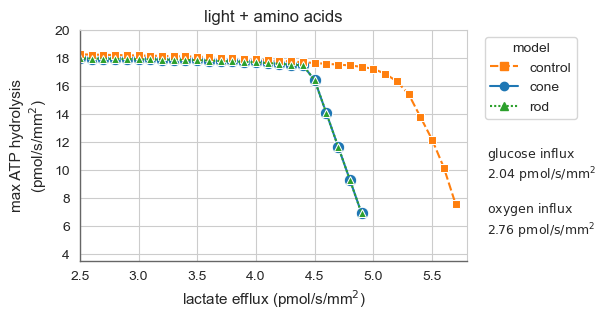

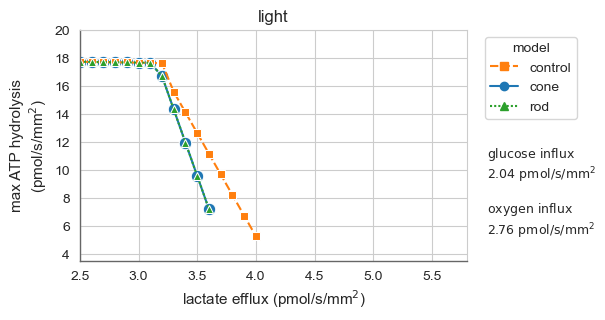

In [ ]:
# load pickes
df_light_no_aas = pd.read_pickle(Path().home() / 'results' / 'df_light_no_aas.pkl')
df_light_aas = pd.read_pickle(Path().home() / 'results' / 'df_light_aas.pkl')
df_dark_no_aas = pd.read_pickle(Path().home() / 'results' / 'df_dark_no_aas.pkl')
df_dark_aas = pd.read_pickle(Path().home() / 'results' / 'df_dark_aas.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

# import MultipleLocator
from matplotlib.ticker import MultipleLocator

# LACTATE SWEEP FIGURES LIGHT

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_aas_lactate_sweep.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/light_aas_lactate_sweep.xlsx')  


# LACTATE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_no_aas_lactate_sweep.png', bbox_inches='tight')
df_light_no_aas.to_excel(results_folder + '/light_no_aas_lactate_sweep.xlsx')  

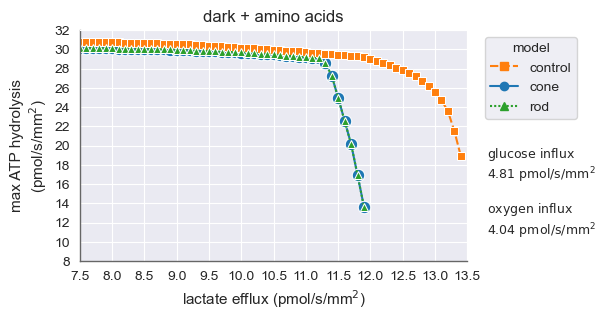

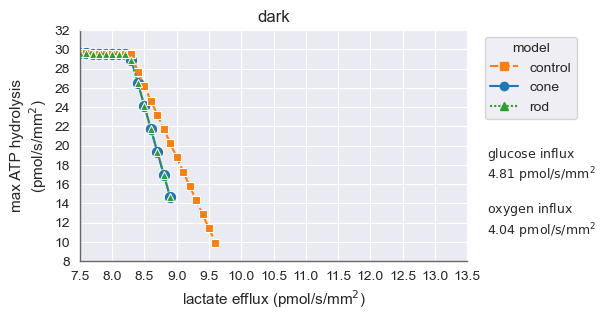

In [30]:
# LACTATE SWEEP FIGURES DARK

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(8,32)
ax.set_xlim(7.5,13.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$4.81\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))
    
fig.savefig(results_folder + '/dark_aas_lactate_sweep.png', bbox_inches='tight')
df_dark_aas.to_excel(results_folder + '/dark_aas_lactate_sweep.xlsx')  


# LACTATE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(8,32)
ax.set_xlim(7.5,13.5)
# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep.png', bbox_inches='tight')
df_dark_no_aas.to_excel(results_folder + '/dark_no_aas_lactate_sweep.xlsx')  

In [31]:
# ####################################################################################################
# ###########                                GLUCOSE SWEEPS                              #############
# ###########                                 LIGHT / DARK                               #############
# ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# ####################################################################################################


# multiplication_factors_light = my_range(1,3,0.1)
# multiplication_factors_dark = my_range(2,5.5,0.1)


# # light
# glucose_RPE_light = 1.84
# glucose_PR_light = 0.2
# glucose_RPEp_light = glucose_RPE_light/(glucose_RPE_light+glucose_PR_light)
# glucose_PRp_light = glucose_PR_light/(glucose_RPE_light+glucose_PR_light)

# # dark
# glucose_RPE_dark = 4.14
# glucose_PR_dark = 0.67
# glucose_RPEp_dark = glucose_RPE_dark/(glucose_RPE_dark+glucose_PR_dark)
# glucose_PRp_dark = glucose_PR_dark/(glucose_RPE_dark+glucose_PR_dark)


# # light
# results_dict_light_no_aas = {}
# results_dict_light_aas = {}
# # dark
# results_dict_dark_no_aas = {}
# results_dict_dark_aas = {}

# for model in combined_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.84, 'RPE')
#             m = open_blood_exchange(m,blood_ratio0,  -0.20, 'PR')

#             glucose_RPE = -glucose_RPEp_light*i
#             glucose_PR = -glucose_PRp_light*i
            
#             ex_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
#                       'MAR09034_RPE':(glucose_RPE,glucose_RPE),\
#                       'MAR04896_PR_RPE':(-2.19,-2.19),\
#                       'MAR09135_RPE':(3.79,3.79),\
#                       'MAR09048_PR':(-0.27,-0.27),\
#                       'MAR09034_PR':(glucose_PR,glucose_PR),\
#                       'MAR09135_PR':(.41,.41)}
#             for ex in ex_bounds_light.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.84, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.20, 'PR')

#             for ex in ex_bounds_light.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas[m.id] = objective_values_light_no_aas
#         results_dict_light_aas[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -4.14, 'RPE')   
#             m = open_blood_exchange(m,blood_ratio0,  -0.67, 'PR')

#             glucose_RPE = -glucose_RPEp_dark*i
#             glucose_PR = -glucose_PRp_dark*i

#             ex_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
#                       'MAR09034_RPE':(glucose_RPE,glucose_RPE),\
#                      'MAR04896_PR_RPE':(-3.18,-3.18),\
#                       'MAR09135_RPE':(7.18,7.18),\
#                       'MAR09048_PR':(-0.56,-0.56),\
#                       'MAR09034_PR':(glucose_PR,glucose_PR),\
#                       'MAR09135_PR':(1.16,1.16)}
#             for ex in ex_bounds_dark.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -4.14, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.67, 'PR')
           
#             for ex in ex_bounds_dark.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds
            
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas[m.id] = objective_values_dark_aas

# df_light_no_aas_glucose = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
# df_light_aas_glucose = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
# df_dark_no_aas_glucose = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
# df_dark_aas_glucose = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# # pickle df_light_no_aas_glucose, df_light_aas_glucose, df_dark_no_aas_glucose, df_dark_aas_glucose

# df_light_no_aas_glucose.to_pickle(Path().home() / 'results' / 'df_light_no_aas_glucose.pkl')
# df_light_aas_glucose.to_pickle(Path().home() / 'results' / 'df_light_aas_glucose.pkl')
# df_dark_no_aas_glucose.to_pickle(Path().home() / 'results' / 'df_dark_no_aas_glucose.pkl')
# df_dark_aas_glucose.to_pickle(Path().home() / 'results' / 'df_dark_aas_glucose.pkl')


In [32]:
# load pickles
df_light_no_aas_glucose = pd.read_pickle(Path().home() / 'results' / 'df_light_no_aas_glucose.pkl')
df_light_aas_glucose = pd.read_pickle(Path().home() / 'results' / 'df_light_aas_glucose.pkl')
df_dark_no_aas_glucose = pd.read_pickle(Path().home() / 'results' / 'df_dark_no_aas_glucose.pkl')
df_dark_aas_glucose = pd.read_pickle(Path().home() / 'results' / 'df_dark_aas_glucose.pkl')

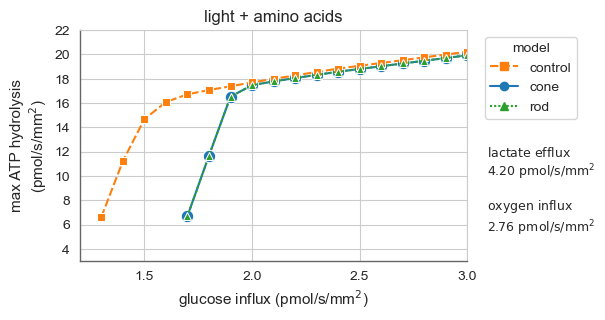

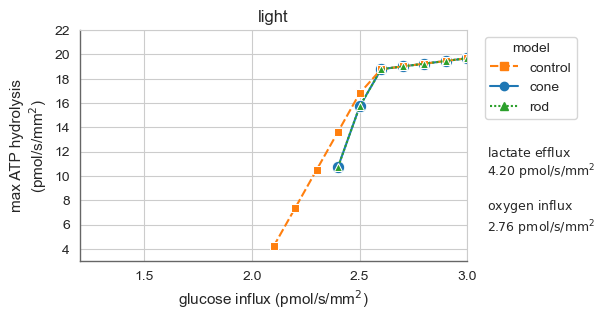

In [33]:
results_folder = create_folder('results', 'paper','sweep', 'glucose')

# GLUCOSE SWEEP FIGURES LIGHT

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3,22)
ax.set_xlim(1.2,3)


# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$4.20\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_aas_glucose_sweep.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/light_aas_glucose_sweep.xlsx')  

# GLUCOSE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3,22)
ax.set_xlim(1.2,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_no_aas_glucose_sweep.png', bbox_inches='tight')
df_light_no_aas.to_excel(results_folder + '/light_no_aas_glucose_sweep.xlsx')  



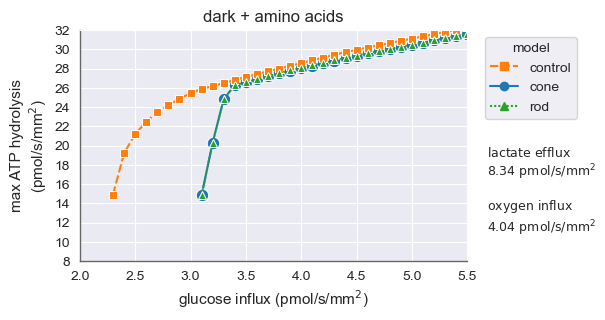

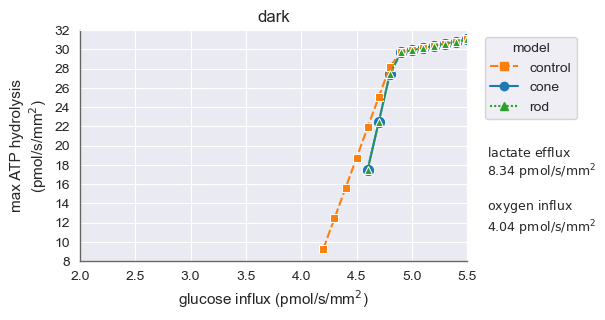

In [34]:
# GLUCOSE SWEEP FIGURES DARK

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(8,32)
ax.set_xlim(2,5.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$8.34\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))
    
fig.savefig(results_folder + '/dark_aas_glucose_sweep.png', bbox_inches='tight')
df_dark_aas_glucose.to_excel(results_folder + '/dark_aas_glucose_sweep.xlsx')  

# GLUCOSE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(8,32)
ax.set_xlim(2,5.5)
# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_glucose_sweep.png', bbox_inches='tight')
df_dark_no_aas_glucose.to_excel(results_folder + '/dark_no_aas_glucose_sweep.xlsx')  


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]
['-', '--', '--', '-', '--', '--']


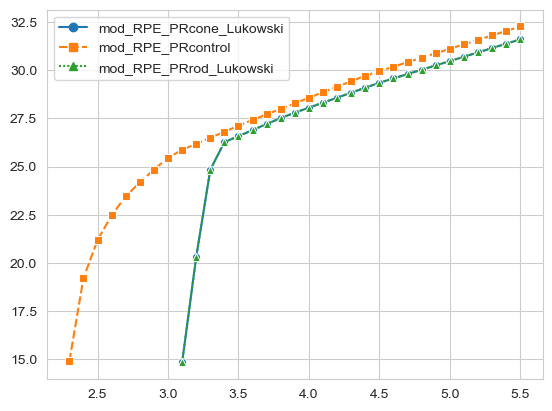

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# create lineplot
fig, ax = plt.subplots()
sns.lineplot(data=df_dark_aas_glucose, markers=['o', 's', '^'], ax=ax)

# fetch color of each line
line_colors = [line.get_color() for line in ax.lines]

# print line colors
print(line_colors)

# get line types of each line
line_types = [line.get_linestyle() for line in ax.lines]

# print line types
print(line_types)

In [56]:
# uncomment to run again (takes ~ 60 min)

####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                 LIGHT / DARK                               #############
###########                         WITH / WITHOUT AMINO ACIDS                         #############
####################################################################################################

def set_rxn_bounds(mod,rxn_dict):

    for key in list(rxn_dict.keys()):
        if key + '_PR' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_PR').bounds = rxn_dict[key]
        elif key + '_RPE' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_RPE').bounds = rxn_dict[key]
        elif key in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key).bounds = rxn_dict[key]
        else: 
            print(key + ' not in model')
    return mod

multiplication_factors_light = my_range(2.5,6,0.1)
multiplication_factors_dark = my_range(7,15,0.1)

# light
results_dict_light_no_aas = {}
results_dict_light_aas = {}
# dark
results_dict_dark_no_aas = {}
results_dict_dark_aas = {}

for model in single_models:
    objective_values_light_aas = []
    objective_values_light_no_aas = []
    objective_values_dark_aas = []
    objective_values_dark_no_aas = []

    with model as m:

        # ################ LIGHT ################

        for i in multiplication_factors_light:
            
            m = open_blood_exchange(m,blood_ratio0, -2.04, '')
            
            ex_bounds_light =    {'MAR09048':(-2.76,-2.76),\
                                  'MAR09034':(-2.04,-2.04),\
                                  'MAR09135':(i,i)}
            

            m = set_rxn_bounds(m,ex_bounds_light)
            #for ex in ex_bounds_light.keys(): 
            #    model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

            m.optimize()
            objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

            m = open_blood_exchange(m,blood_ratio, -2.04, '')

            m.optimize()
            objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

        results_dict_light_no_aas[m.id] = objective_values_light_no_aas
        results_dict_light_aas[m.id] = objective_values_light_aas

        ################ DARK ################

        for i in multiplication_factors_dark:

            m = open_blood_exchange(m,blood_ratio0, -4.81, '')   

            ex_bounds_dark =  {'MAR09048':(-4.04,-4.04),\
                                  'MAR09034':(-4.81,-4.81),\
                                  'MAR09135':(i,i)}
            
            m = set_rxn_bounds(m,ex_bounds_dark)

#            #for ex in ex_bounds_dark.keys(): 
#            #    m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds

            m.optimize()
            objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

            m = open_blood_exchange(m,blood_ratio, -4.81, '')   
            m = set_rxn_bounds(m,ex_bounds_dark)
#            #for ex in ex_bounds_dark.keys(): 
#            #    m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds

            m.optimize()
            objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

        results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
        results_dict_dark_aas[m.id] = objective_values_dark_aas

df_light_no_aas_lactate_single = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
df_light_aas_lactate_single = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
df_dark_no_aas_lactate_single = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
df_dark_aas_lactate_single = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# create results / lactate sweep folder in user folder
results_folder = create_folder('results', 'paper','sweep', 'lactate')

# pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas

df_light_no_aas_lactate_single.to_pickle(Path().home() / 'results' / 'df_light_no_aas_lactate_single.pkl')
df_light_aas_lactate_single.to_pickle(Path().home() / 'results' / 'df_light_aas_lactate_single.pkl')
df_dark_no_aas_lactate_single.to_pickle(Path().home() / 'results' / 'df_dark_no_aas_lactate_single.pkl')
df_dark_aas_lactate_single.to_pickle(Path().home() / 'results' / 'df_dark_aas_lactate_single.pkl')

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

In [66]:
# uncomment to run again (takes ~ 60 min)

####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                 LIGHT / DARK                               #############
###########                         WITH / WITHOUT AMINO ACIDS                         #############
####################################################################################################

def set_rxn_bounds(mod,rxn_dict):

    for key in list(rxn_dict.keys()):
        if key + '_PR' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_PR').bounds = rxn_dict[key]
        elif key + '_RPE' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_RPE').bounds = rxn_dict[key]
        elif key in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key).bounds = rxn_dict[key]
        else: 
            print(key + ' not in model')
    return mod

multiplication_factors_light = my_range(2.5,6,0.1)
multiplication_factors_dark = my_range(7,15,0.1)

# light
results_dict_light_no_aas = {}
results_dict_light_aas = {}
# dark
results_dict_dark_no_aas = {}
results_dict_dark_aas = {}

for model in single_models + Human1_models:
    objective_values_light_aas = []
    objective_values_light_no_aas = []
    objective_values_dark_aas = []
    objective_values_dark_no_aas = []

    with model as m:

        # ################ LIGHT ################

        for i in multiplication_factors_light:
            
            m = open_blood_exchange(m,blood_ratio0, -2.04, '')
            
            ex_bounds_light =    {'MAR09048':(-2.76,-2.76),\
                                  'MAR09034':(-2.04,-2.04),\
                                  'MAR09135':(i,i)}
            

            m = set_rxn_bounds(m,ex_bounds_light)
            #for ex in ex_bounds_light.keys(): 
            #    model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

            m.optimize()
            objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

            m = open_blood_exchange(m,blood_ratio, -2.04, '')

            m.optimize()
            objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

        results_dict_light_no_aas[m.id] = objective_values_light_no_aas
        results_dict_light_aas[m.id] = objective_values_light_aas

                ################ DARK ################

        for i in multiplication_factors_dark:

            m = open_blood_exchange(m,blood_ratio0, -4.81, '')   

            ex_bounds_dark =  {'MAR09048':(-4.04,-4.04),\
                                  'MAR09034':(-4.81,-4.81),\
                                  'MAR09135':(i,i)}
            
            m = set_rxn_bounds(m,ex_bounds_dark)

#            #for ex in ex_bounds_dark.keys(): 
#            #    m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds

            m.optimize()
            objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

            m = open_blood_exchange(m,blood_ratio, -4.81, '')   
            m = set_rxn_bounds(m,ex_bounds_dark)
#            #for ex in ex_bounds_dark.keys(): 
#            #    m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds

            m.optimize()
            objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

        results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
        results_dict_dark_aas[m.id] = objective_values_dark_aas

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

In [68]:
df_light_no_aas_lactate_single = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
df_light_aas_lactate_single = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
df_dark_no_aas_lactate_single = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
df_dark_aas_lactate_single = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# create results / lactate sweep folder in user folder
results_folder = create_folder('results', 'paper','sweep', 'lactate')

# pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas

df_light_no_aas_lactate_single.to_pickle(Path().home() / 'results' / 'df_light_no_aas_lactate_single.pkl')
df_light_aas_lactate_single.to_pickle(Path().home() / 'results' / 'df_light_aas_lactate_single.pkl')
df_dark_no_aas_lactate_single.to_pickle(Path().home() / 'results' / 'df_dark_no_aas_lactate_single.pkl')
df_dark_aas_lactate_single.to_pickle(Path().home() / 'results' / 'df_dark_aas_lactate_single.pkl')

In [86]:
df_light_aas_lactate_single

,mod_RPE_PRcone_Lukowski_singlePR,mod_RPE_PRcone_Lukowski_singleRPE,mod_RPE_PRrod_Lukowski_singlePR,mod_RPE_PRrod_Lukowski_singleRPE,Human-GEM_28062023
2.5,17.131311,17.629929,17.289007,17.629929,18.261553
2.6,17.006311,17.580126,17.269007,17.580126,18.245644
2.7,16.881311,17.530126,17.249007,17.530126,18.229734
2.8,16.756311,17.480126,17.229007,17.480126,18.213825
2.9,16.631311,17.430126,17.209007,17.430126,18.197916
3.0,16.506311,17.380126,17.189007,17.380126,18.182007
3.1,16.381311,17.330126,17.169007,17.330126,18.166098
3.2,16.256311,17.280126,17.149007,17.280126,18.150189
3.3,16.131311,17.230126,17.129007,17.230126,18.134280
3.4,16.006311,17.180126,17.098097,17.180126,18.118371


C:\Users\prins\AppData\Local\Temp\ipykernel_17972\4193896383.py:93: UserWarning: 
The markers list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df_light_no_aas_lactate_single,markers=['o','s','^'],ax=ax)


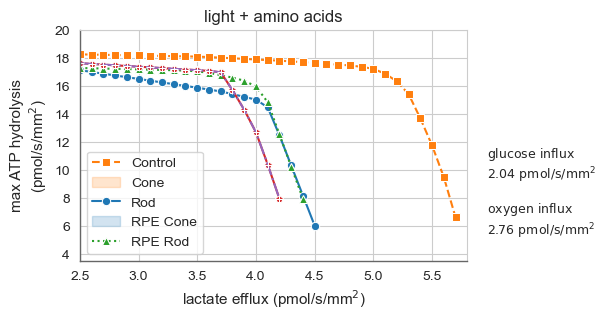

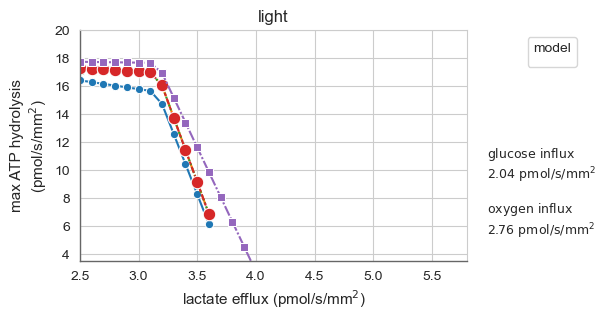

In [117]:
# load pickes
df_light_no_aas_lactate_single = pd.read_pickle(Path().home() / 'results' / 'df_light_no_aas_lactate_single.pkl')
df_light_aas_lactate_single = pd.read_pickle(Path().home() / 'results' / 'df_light_aas_lactate_single.pkl')
df_dark_no_aas_lactate_single = pd.read_pickle(Path().home() / 'results' / 'df_dark_no_aas_lactate_single.pkl')
df_dark_aas_lactate_single = pd.read_pickle(Path().home() / 'results' / 'df_dark_aas_lactate_single.pkl')

# colours
orange = (1.0, 0.4980392156862745, 0.054901960784313725)
blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
green = (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
red = (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
purple = (0.5803921568627451, 0.403921568627451, 0.7411764705882353)

# import MultipleLocator
from matplotlib.ticker import MultipleLocator

# LACTATE SWEEP FIGURES LIGHT

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE


# add legend
plt.legend(['Control', 'Cone', 'Rod', 'RPE Cone', 'RPE Rod'])

#lineplot(data=df_light_aas_lactate_single,markers=['o','s','^','p'],ax=ax)
# #change marker size
# ax.lines[0].set_markersize(9)
# ax.lines[1].set_markersize(6)
# ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)


# # change labels of legend
#handles, labels = ax.get_legend_handles_labels()
#handles = [handles[1], handles[0], handles[2]]
#labels = ['control', 'cone', 'rod']

#ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

##fig.savefig(results_folder + '/light_aas_lactate_sweep.png', bbox_inches='tight')
##df_light_aas.to_excel(results_folder + '/light_aas_lactate_sweep.xlsx')  


# LACTATE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_lactate_single,markers=['o','s','^'],ax=ax)
# #change marker size
ax.lines[0].set_markersize(6)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)
ax.lines[3].set_markersize(9)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# # change labels of legend
# handles, labels = ax.get_legend_handles_labels()
# handles = [handles[1], handles[0], handles[2]]
# labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

##fig.savefig(results_folder + '/light_no_aas_lactate_sweep.png', bbox_inches='tight')
##df_light_no_aas.to_excel(results_folder + '/light_no_aas_lactate_sweep.xlsx')  

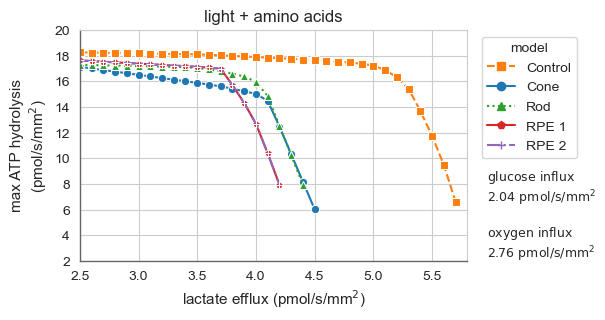

In [151]:
# load pickes
df_light_no_aas_lactate_single = pd.read_pickle(Path().home() / 'results' / 'df_light_no_aas_lactate_single.pkl')
df_light_aas_lactate_single = pd.read_pickle(Path().home() / 'results' / 'df_light_aas_lactate_single.pkl')
df_dark_no_aas_lactate_single = pd.read_pickle(Path().home() / 'results' / 'df_dark_no_aas_lactate_single.pkl')
df_dark_aas_lactate_single = pd.read_pickle(Path().home() / 'results' / 'df_dark_aas_lactate_single.pkl')

# colours
orange = (1.0, 0.4980392156862745, 0.054901960784313725)
blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
green = (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
red = (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
purple = (0.5803921568627451, 0.403921568627451, 0.7411764705882353)

# import MultipleLocator
from matplotlib.ticker import MultipleLocator

# LACTATE SWEEP FIGURES LIGHT

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE


# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

#lineplot(data=df_light_aas_lactate_single,markers=['o','s','^','p'],ax=ax)
# #change marker size
# ax.lines[0].set_markersize(9)
# ax.lines[1].set_markersize(6)
# ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(2,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_aas_lactate_sweep_single.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/light_aas_lactate_sweep_single.xlsx')  

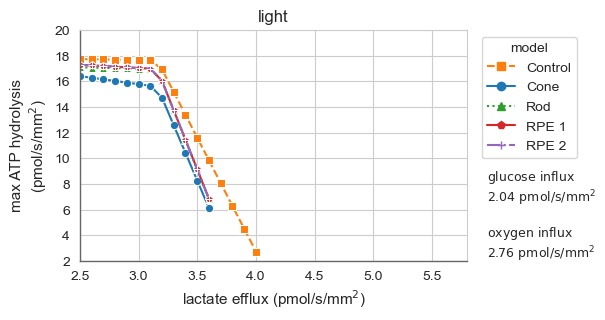

In [152]:

# LACTATE SWEEP FIGURES LIGHT WITHOUT AMINO ACIDS

sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(2,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((r'$\mathrm{glucose\ influx}$', r'$2.04\ \mathrm{pmol/s/mm}^2$', r'', r'$\mathrm{oxygen\ influx}$', r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_lactate_sweep_single.png', bbox_inches='tight')
df_light_no_aas_lactate_single.to_excel(results_folder + '/light_lactate_sweep_single.xlsx')

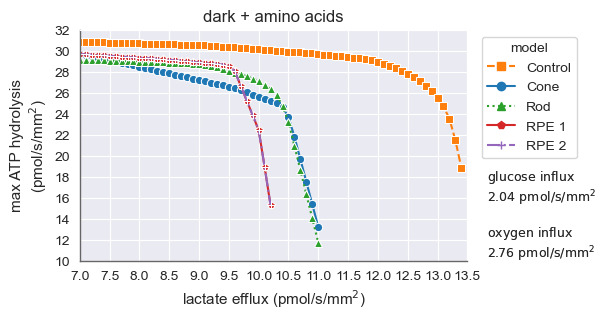

In [159]:
# LACTATE SWEEP FIGURES DARK



# LACTATE SWEEP FIGURES LIGHT WITHOUT AMINO ACIDS

sns.set_style("darkgrid", {'axes.grid' : True})

fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE
sns.set_style("whitegrid", {'axes.grid' : True})
# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend darkgrid
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(2,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((r'$\mathrm{glucose\ influx}$', r'$2.04\ \mathrm{pmol/s/mm}^2$', r'', r'$\mathrm{oxygen\ influx}$', r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_lactate_sweep_single.png', bbox_inches='tight')
df_light_no_aas_lactate_single.to_excel(results_folder + '/light_lactate_sweep_single.xlsx')
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(10,32)
ax.set_xlim(7,13.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((r'$\mathrm{glucose\ influx}$', r'$2.04\ \mathrm{pmol/s/mm}^2$', r'', r'$\mathrm{oxygen\ influx}$', r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_aas_lactate_sweep_single.png', bbox_inches='tight')
df_dark_aas_lactate_single.to_excel(results_folder + '/dark_aas_lactate_sweep_single.xlsx')

In [ ]:
# colours
orange = (1.0, 0.4980392156862745, 0.054901960784313725)
blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
green = (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
red = (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
purple = (0.5803921568627451, 0.403921568627451, 0.7411764705882353)

# import MultipleLocator
from matplotlib.ticker import MultipleLocator

# LACTATE SWEEP FIGURES DARK

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(2,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((r'$\mathrm{glucose\ influx}$', r'$2.04\ \mathrm{pmol/s/mm}^2$', r'', r'$\mathrm{oxygen\ influx}$', r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep_single.png', bbox_inches='tight')
df_dark_aas_lactate_single.to_excel(results_folder + '/dark_no_aas_lactate_sweep_single.xlsx')

In [ ]:
# GLUCOSE SWEEP SINGLE MODELS

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

multiplication_factors = [round(x * .01, 2) for x in range(0, 150, 1)]


results_dict_light = {}

for model in single_models + Human1_models:
    objective_values = []
    with model as m:
        m = open_blood_exchange(m,blood_ratio, -2.04, '')
        reaction_list = [r.id for r in m.reactions]
        for i in multiplication_factors:
            glucose = (-2.04)*i
            single_ex_bounds_light = {'MAR09048':(-2.76,-2.76),\
                        'MAR09034':(glucose,glucose),\
                        'MAR09135':(4.21,4.21)}
            for ex in single_ex_bounds_light.keys(): 
                if ex + '_RPE' in reaction_list:
                    m.reactions.get_by_id(ex+ '_RPE').bounds = single_ex_bounds_light[ex] # set exchange bounds
                elif ex + '_PR' in reaction_list:
                    m.reactions.get_by_id(ex+ '_PR').bounds = single_ex_bounds_light[ex]
                elif ex in reaction_list:
                    m.reactions.get_by_id(ex).bounds = single_ex_bounds_light[ex]
                else:
                    print (ex + ' not in model')
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_light[m.id] = objective_values

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2')
df2_single = pd.DataFrame(results_dict_light,index=[m*(2.04) for m in multiplication_factors])


c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2


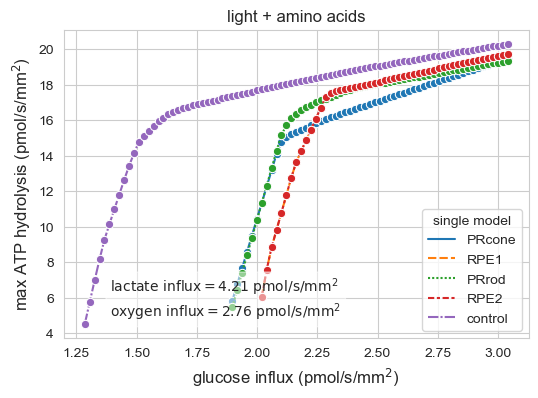

In [ ]:
# GLUCOSE SWEEP

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df2_single,marker='o',ax=ax)
plt.xlabel('glucose influx (pmol/s/mm$^2$)', fontsize=12)
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)', fontsize=12)
plt.title('light + amino acids')

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ influx} = 4.21\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 2.76\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.1, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
#handles = [handles[1], handles[0], handles[2]]
labels = ['PRcone', 'RPE1', 'PRrod','RPE2','control']
ax.legend(handles, labels, title='single model')
# move legend outside of plot
#ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# set x axis limits


def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path
    
results_folder = create_folder('results', 'sweep', 'light')
fig.savefig(results_folder + '/light_glucose_aas_sweep_SINGLE.png', bbox_inches='tight')
df2_single.to_excel(results_folder + '/light_glucose_aas_sweep_SINGLE.xlsx')  

In [ ]:
# GLUCOSE SWEEP SINGLE MODELS (LESS FINEGRAINED BUT HIGHER MAX GLUC)

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

multiplication_factors = [round(x * .01, 2) for x in range(0, 500, 10)]


results_dict_light = {}

for model in single_models + Human1_models:
    objective_values = []
    with model as m:
        m = open_blood_exchange(m,blood_ratio, -2.04, '')
        reaction_list = [r.id for r in m.reactions]
        for i in multiplication_factors:
            glucose = (-2.04)*i
            single_ex_bounds_light = {'MAR09048':(-2.76,-2.76),\
                        'MAR09034':(glucose,glucose),\
                        'MAR09135':(4.21,4.21)}
            for ex in single_ex_bounds_light.keys(): 
                if ex + '_RPE' in reaction_list:
                    m.reactions.get_by_id(ex+ '_RPE').bounds = single_ex_bounds_light[ex] # set exchange bounds
                elif ex + '_PR' in reaction_list:
                    m.reactions.get_by_id(ex+ '_PR').bounds = single_ex_bounds_light[ex]
                elif ex in reaction_list:
                    m.reactions.get_by_id(ex).bounds = single_ex_bounds_light[ex]
                else:
                    print (ex + ' not in model')
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_light[m.id] = objective_values

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2')
df2_single_500 = pd.DataFrame(results_dict_light,index=[m*(2.04) for m in multiplication_factors])


c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2


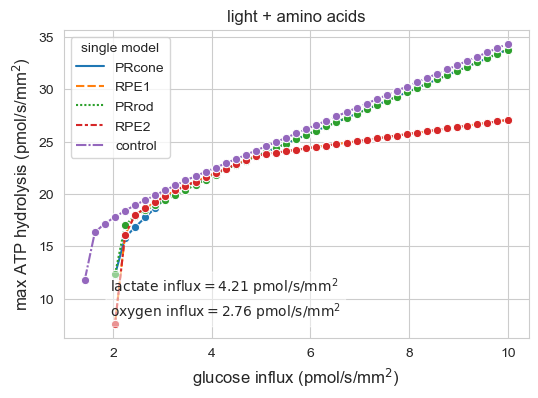

In [ ]:
# GLUCOSE SWEEP

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df2_single_500,marker='o',ax=ax)
plt.xlabel('glucose influx (pmol/s/mm$^2$)', fontsize=12)
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)', fontsize=12)
plt.title('light + amino acids')

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ influx} = 4.21\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 2.76\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.1, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
#handles = [handles[1], handles[0], handles[2]]
labels = ['PRcone', 'RPE1', 'PRrod','RPE2','control']
ax.legend(handles, labels, title='single model')
# move legend outside of plot
#ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# set x axis limits


def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path
    
results_folder = create_folder('results', 'sweep', 'light')
fig.savefig(results_folder + '/light_glucose_aas_sweep_SINGLE500.png', bbox_inches='tight')
df2_single_500.to_excel(results_folder + '/light_glucose_aas_sweep_SINGLE500.xlsx')  

In [ ]:
# DARK
# GLUCOSE SWEEP SINGLE MODELS 

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

#       		 choroid	retinal	total
#   oxygen influx	3.48	0.56	4.04
#	glucose influx	4.14	0.67	4.81
#	lactate efflux	7.18	1.16	8.34


multiplication_factors = [round(x * .01, 2) for x in range(0, 500, 10)]

results_dict_dark = {}

for model in single_models + Human1_models:
    objective_values = []
    with model as m:
        m = open_blood_exchange(m,blood_ratio,  -14.81, '')
        reaction_list = [r.id for r in m.reactions]
        for i in multiplication_factors:
            glucose = (-4.81)*i
            single_ex_bounds_dark = {'MAR09048':(-4.04,-4.04),\
                        'MAR09034':(glucose,glucose),\
                        'MAR09135':(8.34,8.34)}
            for ex in single_ex_bounds_dark.keys(): 
                if ex + '_RPE' in reaction_list:
                    m.reactions.get_by_id(ex+ '_RPE').bounds = single_ex_bounds_dark[ex] # set exchange bounds
                elif ex + '_PR' in reaction_list:
                    m.reactions.get_by_id(ex+ '_PR').bounds = single_ex_bounds_dark[ex]
                elif ex in reaction_list:
                    m.reactions.get_by_id(ex).bounds = single_ex_bounds_dark[ex]
                else:
                    print (ex + ' not in model')
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_dark[m.id] = objective_values

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2')
df2_single_dark500 = pd.DataFrame(results_dict_dark,index=[m*(4.81) for m in multiplication_factors])


c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2


In [ ]:
# DARK
# GLUCOSE SWEEP SINGLE MODELS 

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

#       		 choroid	retinal	total
#   oxygen influx	3.48	0.56	4.04
#	glucose influx	4.14	0.67	4.81
#	lactate efflux	7.18	1.16	8.34


multiplication_factors = [round(x * .01, 2) for x in range(0, 150, 1)]

results_dict_dark = {}

for model in single_models + Human1_models:
    objective_values = []
    with model as m:
        m = open_blood_exchange(m,blood_ratio,  -14.81, '')
        reaction_list = [r.id for r in m.reactions]
        for i in multiplication_factors:
            glucose = (-4.81)*i
            single_ex_bounds_dark = {'MAR09048':(-4.04,-4.04),\
                        'MAR09034':(glucose,glucose),\
                        'MAR09135':(8.34,8.34)}
            for ex in single_ex_bounds_dark.keys(): 
                if ex + '_RPE' in reaction_list:
                    m.reactions.get_by_id(ex+ '_RPE').bounds = single_ex_bounds_dark[ex] # set exchange bounds
                elif ex + '_PR' in reaction_list:
                    m.reactions.get_by_id(ex+ '_PR').bounds = single_ex_bounds_dark[ex]
                elif ex in reaction_list:
                    m.reactions.get_by_id(ex).bounds = single_ex_bounds_dark[ex]
                else:
                    print (ex + ' not in model')
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_dark[m.id] = objective_values

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2')
df2_single_dark = pd.DataFrame(results_dict_dark,index=[m*(4.81) for m in multiplication_factors])


c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2


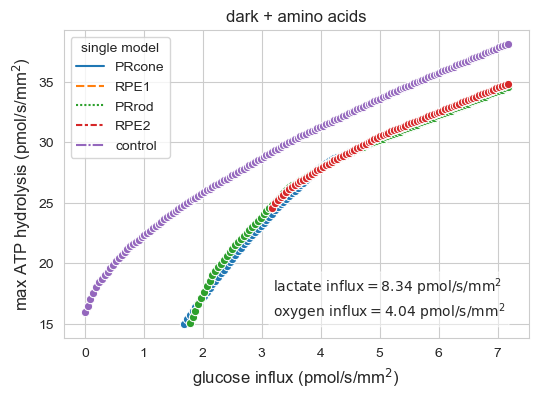

In [ ]:
# GLUCOSE SWEEP

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df2_single_dark,marker='o',ax=ax)
plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=12)
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)',fontsize=12)
plt.title('dark + amino acids')

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ influx} = 8.34\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 4.04\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.45, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
#handles = [handles[1], handles[0], handles[2]]
labels = ['PRcone', 'RPE1', 'PRrod','RPE2','control']
ax.legend(handles, labels, title='single model')
# move legend outside of plot
#ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# set x axis limits


def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path
    
results_folder = create_folder('results', 'sweep', 'dark')
fig.savefig(results_folder + '/dark_glucose_aas_sweep_SINGLE.png', bbox_inches='tight')
df2_single_dark.to_excel(results_folder + '/dark_glucose_aas_sweep_SINGLE.xlsx')  